In [1]:
laptop = False

if laptop:
    rootF = 'C:/Users/goethas/'
else:
    rootF = '/home/sarah/'

In [2]:
import os
import sys
from matplotlib.pyplot import *
from numpy import *
from tqdm.auto import tqdm
import itertools
import csv
import h5py
import matplotlib.gridspec as gds
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.patches as pcs
import pickle
import pandas as pd
from scipy.io import loadmat
from scipy import interpolate

# Import diverse functions
from shared.functions import fit_gaussian, get_ellipse_parameters, plot_dendrogram
from shared.save_load import *

# For clustering
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

# Load data

### Baden data

In [3]:
Folder = rootF + '/Documents/Myopia/Data analysis/calcium_comparison/'

# Baden data
baden = loadmat(Folder + 'baden_data.mat')
# Calcium transform data
calcium = loadmat(Folder + 'calcium_conversion.mat')

chirp_stim = baden['chirp_stim'][:,0]/max(baden['chirp_stim'][:,0]) # the stimulus
chirp_stim_time = baden['chirp_stim_time'][0,:] + 2   # the stimulus times, 2 seconds later than my stim
baden_time_original = baden['chirp_time'][0,:]   # 2 seconds later than my stim
group_idx = baden['group_idx'] 
psth_euler = baden['chirp_avg'] # the average calcium traces

# Baden types : load cell types names
euler_labels_f = open(Folder + 'Baden Types');
euler_labels_f = csv.reader(euler_labels_f,delimiter=",");
euler_labels={}
c=0
for row in euler_labels_f:
    if c==0:
        stim_cond_head = row
        c=1
    else:
        euler_labels[c-1]= row
        c+=1     
        
n_baden_types = len(euler_labels)

In [4]:
print ('Euler labels :', n_baden_types, 'types')
for i in euler_labels:
    print(i, euler_labels[i][0])

Euler labels : 32 types
0 OFF local OS
1 OFF DS
2 OFF step
3 OFF slow
4 OFF alpha sustained
5 ON-OFF JAM-B
6 OFF sustained
7 OFF alpha transient
8 OFF mini alpha transient
9 ON-OFF local-edge W3
10 ON-OFF local
11 ON-OFF DS 1
12 ON-OFF DS 2
13 ON-OFF local OS
14 ON step
15 ON DS transient
16 ON local transient OS
17 ON transient
18 ON transient large
19 ON high frequency
20 ON low frequency
21 ON sustained
22 ON mini alpha
23 ON alpha
24 ON DS sustained 1
25 ON DS sustained 2
26 ON slow
27 ON constrast suppression
28 ON DS sustained 3
29 ON local sustained OS
30 OFF suppression 1
31 OFF suppression 2


### Our chirp stimulation

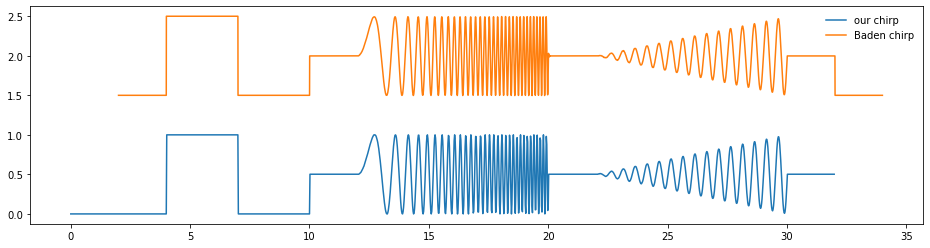

In [5]:
# Get Euler stim profile

def get_euler():
    if laptop:
        vec_path = 'D:/MEA data/exp19/STIMS/Euler/'
    else:
        vec_path = '/media/sarah/Sarah_1/MEA data/exp19/STIMS/Euler/'
    vec_path = vec_path + r"euler.vec"
    euler_vec = np.genfromtxt(vec_path)

    return (euler_vec[150:1750,1]/max(euler_vec[150:1750,1])) #return in 100ms steps

euler_vec = get_euler()

# Plot
figure(figsize = (16,4))
time_stim = np.linspace(0,32,50*32+1)[:-1]
time = np.linspace(0,32,321)[:-1]
# Our chirp
plot(time_stim, euler_vec, label='our chirp')
euler_vec.shape
euler_vec[::5].shape,time.shape
# Baden chirp
plot(chirp_stim_time ,chirp_stim+1.5, label = 'Baden chirp')
chirp_stim_time.shape, chirp_stim.shape
legend(frameon=False)

# Comparison range:
comp_range = [0.1,31.9]         # to avoid prestep effects ### why 0.1 and not 2 ?
delta_range = comp_range[1]-comp_range[0]
time_common = np.linspace(comp_range[0],comp_range[1],int(delta_range/0.05) +2)

### Euler calcium data

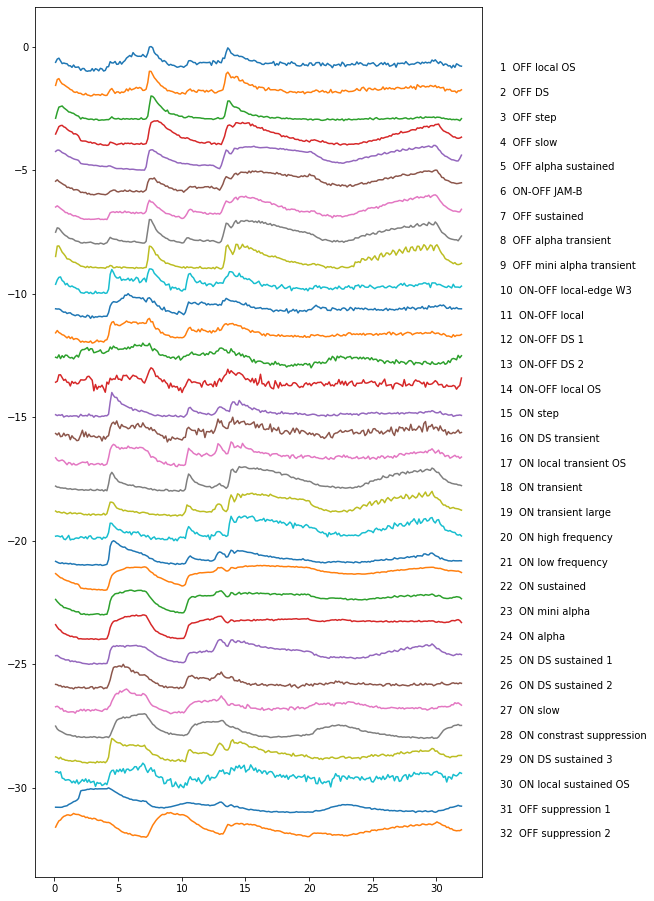

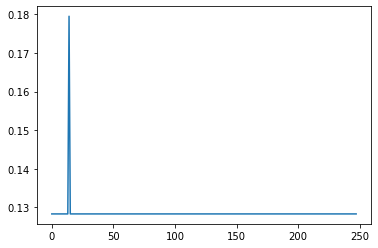

In [6]:
# Generate Baden type traces

# the two additional seconds at the end of Baden stim that will be stitched in the beginning
baden_time = baden_time_original+2
baden_first = baden_time[-15:]-32 
baden_time = np.append(baden_first,baden_time[:-15])

# we do the same for the calcium traces
Baden_types = []

figure(figsize=(8,16))

for i in np.arange(n_baden_types)+1:
    trace = np.mean(psth_euler[:,(group_idx==i)[:,0]],1)
    trace = trace-min(trace)
    trace = trace/max(trace)
    trace = np.append(trace[-15:],trace[:-15])                # I stitch las 2 s in the beggining so that it is 
                                                              #  the same as my experimental stim
    Baden_types.append(trace)
    plot(baden_time,trace-i)
    text(35,-i,str(i)+'  '+euler_labels[i-1][0])

figure()
plot(diff(baden_time))

### Clustering results

From Analyse_cell_type.ipynb

In [7]:
# experiment data
exp = 20211129
exp_path = rootF + '/Documents/Myopia/Data analysis/Blur experiments/exp' + str(exp) + '/'
clustering_data = exp_path + str(exp) + '_clustermodel'
model, psth_z = load_obj(clustering_data)

labels = model.labels_
exp_labels = np.sort(np.unique(labels))
psth_z.shape, 'Ncells  - Ndatapoints'

((68, 320), 'Ncells  - Ndatapoints')

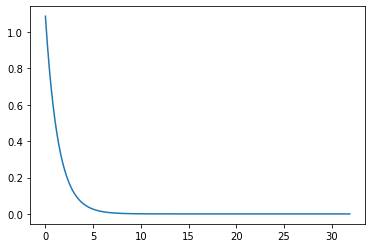

In [8]:
# functions for calcium traces

def calcium_exp(x):
    a =           0
    b =       1.086 
    c =       1.747 -1.0              ##################### changes here
    val = a+b*np.exp(-c*x)
    return val

def toCalciumLinear(time_sequence, spike_train):
    calcium_filter = calcium_exp(time_sequence);
    
    stitch3 = np.append(spike_train,[spike_train,spike_train])
    
    calcium_trace = np.convolve(stitch3, calcium_filter, 'full')[len(spike_train):len(spike_train)*2];
    calcium_trace = calcium_trace-min(calcium_trace)
    calcium_trace=calcium_trace/max(calcium_trace)
    return calcium_trace
    

calcium_filter = calcium_exp(time);
plot(time,calcium_filter)

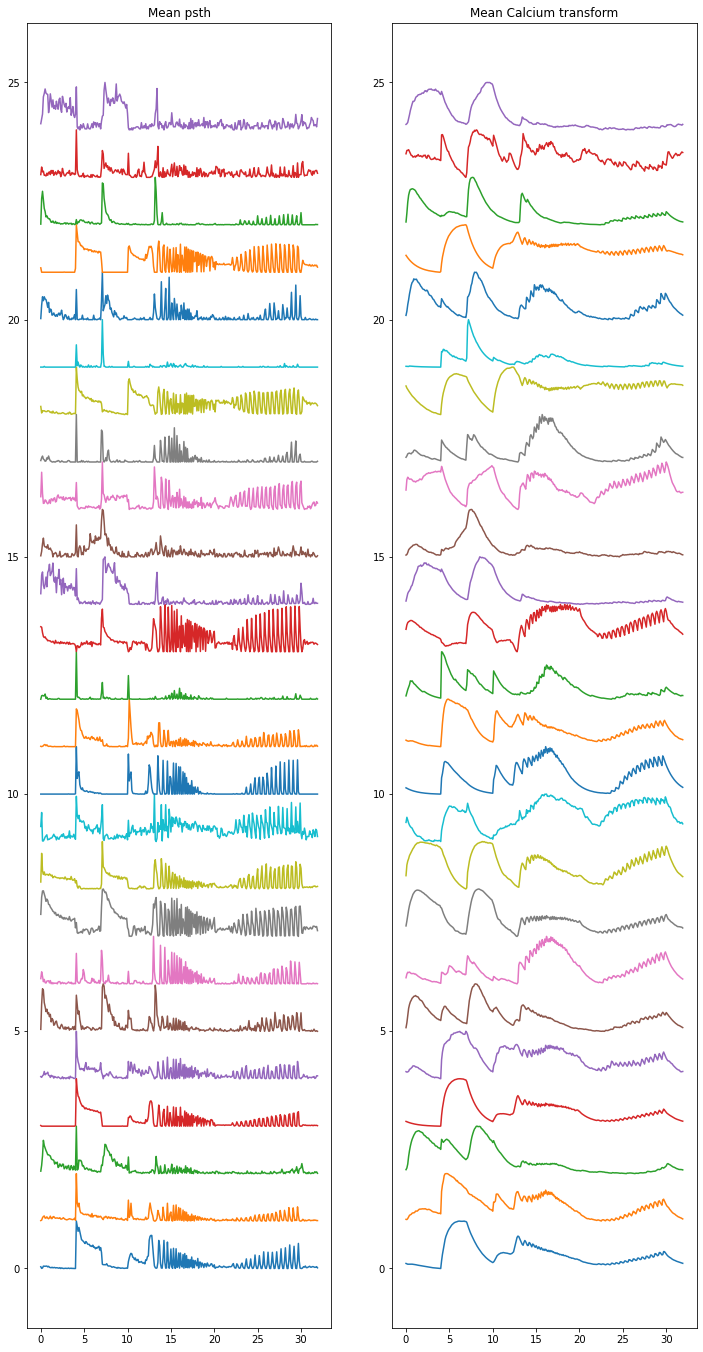

In [9]:
# Generate experiment type traces
Exp_types = []
fig = figure(figsize=(12,24))
fig.add_subplot(1,2,1)
for i in exp_labels:
    trace = np.mean(psth_z[(labels==i),:],0)
    trace = trace-min(trace)
    trace = trace/max(trace)
    Exp_types.append(trace)
    plot(time,trace+i)
    title('Mean psth')

# Experiment to calcium
Exp_types_Ca = {}
fig.add_subplot(1,2,2)
for i in exp_labels:
    trace = toCalciumLinear(time,Exp_types[i])
    Exp_types_Ca[i] = trace
    plot(time,trace+i)
    title('Mean Calcium transform')

# Correlate groups

In [10]:
# Interpolate calcium traces (Baden and transformed traces)
Baden_common = {}
for i in np.arange(n_baden_types):
    f = interpolate.interp1d(baden_time, Baden_types[i])
    Baden_common[i] = f(time_common)   # use interpolation function returned by `interp1d`

Exp_common={}
for i in exp_labels:
    f = interpolate.interp1d(time, Exp_types_Ca[i])
    Exp_common[i] = f(time_common)   # use interpolation function returned by `interp1d`

n_matches = 29
corr_table = np.zeros([len(exp_labels),n_baden_types]) 
corr_match = np.zeros([len(exp_labels),n_baden_types])
corr_match_vals = np.zeros([len(exp_labels),n_baden_types])
delta_match = np.zeros([len(exp_labels),n_baden_types+1])

# For each of our generated calcium type we compute the corr coef with each Baden type
for i in exp_labels:
    for j in np.arange(n_baden_types):
        corr_table[i,j] = np.corrcoef(Exp_common[i], Baden_common[j])[0,1]
    # For each calcium type, sort de corr coefs in descending order (max first)
    corr_match[i,:] = np.flip(np.argsort(corr_table[i,:])[-32:]) # sorted indices
    corr_match_vals[i,:] = corr_table[i,:][np.flip([np.argsort(corr_table[i,:])[-32:]])] # sorted corr coef values
    # Select the 10 larger corr coefs and store the difference with the next one
    for j in np.arange(10):
        delta_match[i,j] = corr_match_vals[i,j]-corr_match_vals[i,j+1]  

['OFF suppression 1']


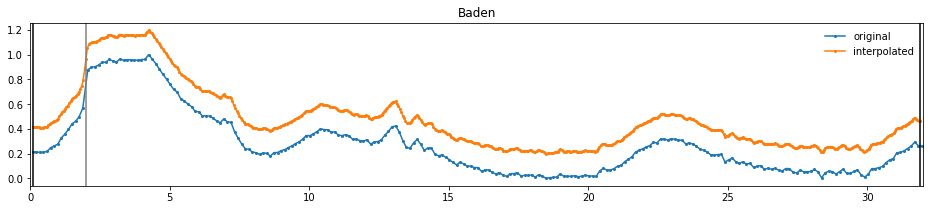

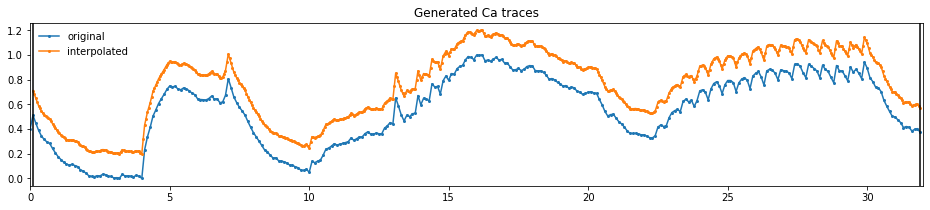

In [11]:
# Compare original and interpolated traces

# Baden traces
figure(figsize=(16,3))
idx = 30
title('Baden')
plot(baden_time, Baden_types[idx], '-o', ms=2, label = 'original')
plot(time_common, Baden_common[idx]+0.2, 'o-', ms=2, label = 'interpolated')
axvline(comp_range[0],color='k')
axvline(comp_range[1],color='k')
axvline(2,color='gray')
xlim([0,32])
legend(frameon=False)
print(euler_labels[idx])

# Generated calcium traces
figure(figsize=(16,3))
idx = 9
title('Generated Ca traces')
plot(time, Exp_types_Ca[idx], '-o', ms=2, label='original')
plot(time_common, Exp_common[idx]+0.2, 'o-', ms=2, label='interpolated')
axvline(comp_range[0],color='k')
axvline(comp_range[1],color='k')
xlim([0,32])    
legend(frameon=False)


(array([0.83773542, 0.84342675, 0.86390579, 0.88027644, 0.88307734,
        0.88455722, 0.88540391, 0.8911465 , 0.8978903 , 0.90215812]),
 0.8085370225498544,
 0.7786873949490386)

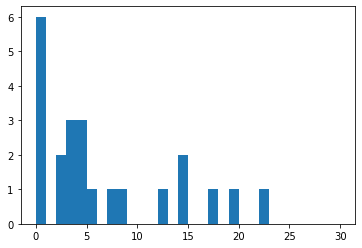

In [12]:
# Histogram of the difference between the first and second corr coef, for all cells
hist(delta_match[:,0]*100, bins=linspace(0,30,31))

np.sort(corr_match_vals[:,0])[-10:], np.median(corr_match_vals[:,0]), np.mean(corr_match_vals[:,0])

(array([0., 1., 3., 0., 1., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0.,
        1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 3., 4., 0.]),
 array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5]),
 <BarContainer object of 32 artists>)

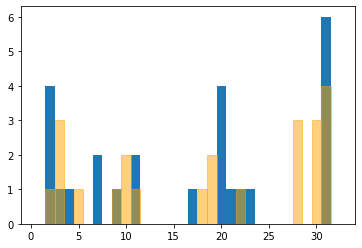

In [13]:
# Histo of the indices of first and second largest corr coefs
hist(corr_match[:,0], bins=np.arange(33)+0.5)
hist(corr_match[:,1], bins=np.arange(33)+0.5,fc='orange',ec='orange',alpha=0.5)

# Manual selection of Groups

In [14]:
fsave = exp_path + 'cells_characterization_data_with_cluster_type_' + str(exp) 
cell_data = load_obj(fsave)

fsave = exp_path + str(exp) + '_selected_cells_clustering'
selected_cells = np.array(load_obj(fsave))

match 7   7 Baden  1
match 1   7 Baden  2
match 2   7 Baden  3
match 5   7 Baden  4
match 9   7 Baden  7
match 6   7 Baden  8
match 4   7 Baden  12
match 8   7 Baden  13
match 3   7 Baden  30
match 0   7 Baden  31


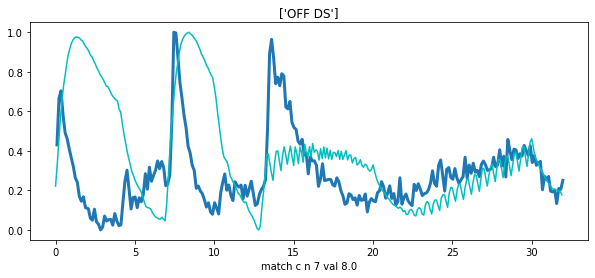

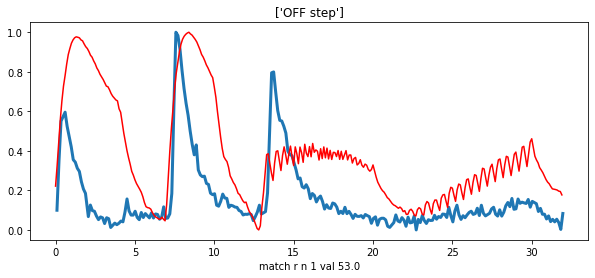

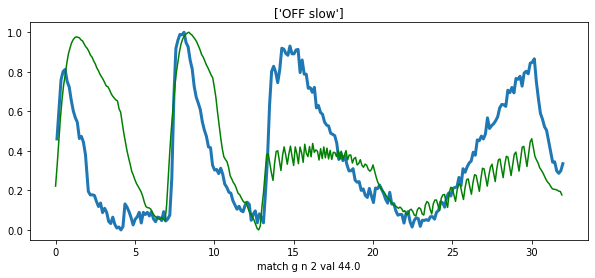

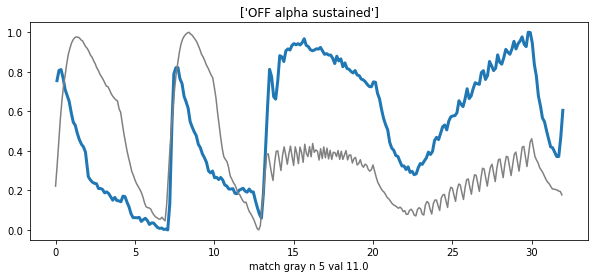

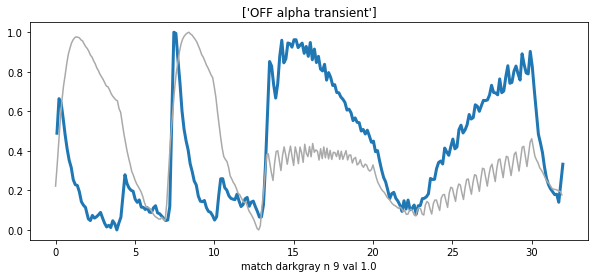

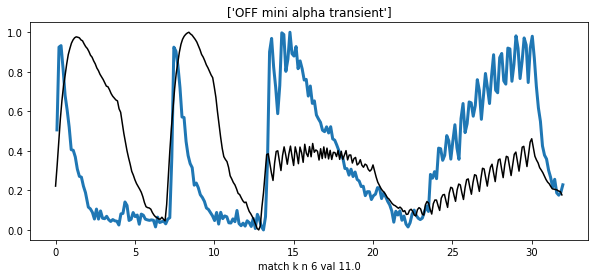

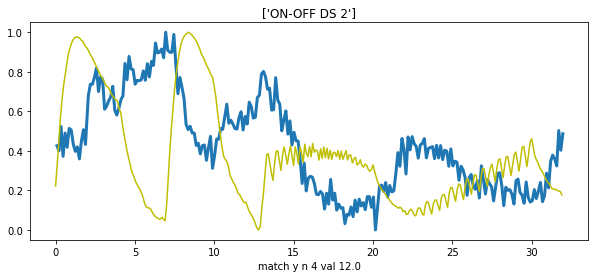

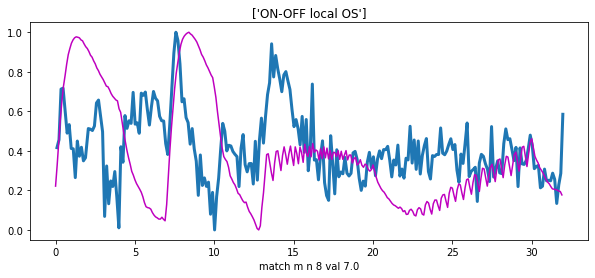

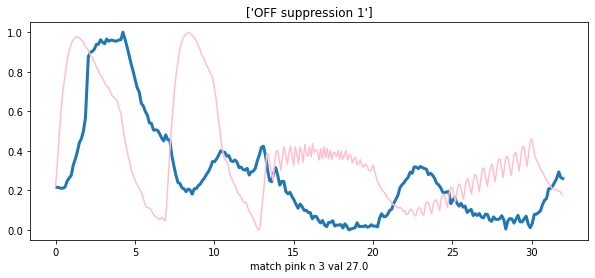

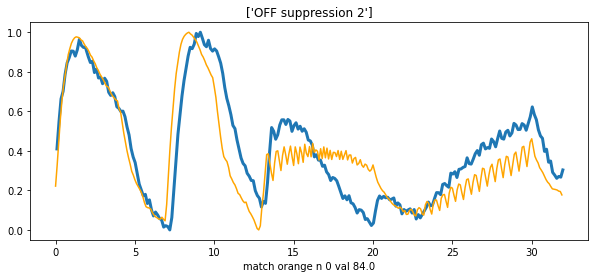

In [18]:
sel_badens = np.arange(32)

# The generated calcium trace we look at
sel_cells = [7]

n_match_sel = 10 # number of best matching Baden traces we look at for manual selection

colors = ['orange','r','g','pink','y','gray','k','c','m','darkgray','coral','gold','plum','wheat','navy']
#             0     1   2    3     4    5     6   7   8      9         10      11     12      13     14

# For each generated calcium trace we look at the first 5 best matching Baden traces
for i in sel_badens:
    Plot = False
    for j in sel_cells:
        for n_match in np.arange(n_match_sel):
            if corr_match[j, n_match]==i:
                if not(Plot): 
                    figure(figsize=(10,4))
                    plot(baden_time, Baden_types[i],lw=3)
                    title(euler_labels[i])
                    Plot=True
                if Plot:
                    plot(time, Exp_types_Ca[j],color=colors[n_match%15])
                    xlabel('match '+colors[n_match%15]+' n ' +str(n_match)+' val '+str(np.round(corr_match_vals[j,n_match]*100)) )
                    print('match', str(n_match),' ', j, 'Baden ',i)
                    
# Manually selected Baden types
manual_selection = corr_match[:,0].astype('int')
# indices are cluster groupe number, n match
manual_selection[0] = corr_match[0,5] # ON local trans OS
manual_selection[1] = corr_match[1,0] # ON low freq
manual_selection[2] = corr_match[2,4] # ON OFF local OS 
manual_selection[3] = corr_match[3,12] # ON mini alpha
manual_selection[4] = corr_match[4,4] # ON DS sust 1
manual_selection[5] = corr_match[5,3] # ON OFF local edge
manual_selection[6] = corr_match[6,1] # ON high freq
manual_selection[7] = corr_match[7,5] # OFF alpha sustained
manual_selection[8] = corr_match[8,1] # OFF slow
manual_selection[9] = corr_match[9,0] # ON sustained
manual_selection[10] = corr_match[10,2] # ON transient large
manual_selection[11] = corr_match[11,1] # ON DS sust 3
manual_selection[12] = corr_match[12,2] # ON step
manual_selection[13] = corr_match[13,1] # ON OFF jam B 
manual_selection[14] = corr_match[14,1] # OFF supp 1
manual_selection[15] = corr_match[15,0] # OFF step
manual_selection[16] = corr_match[16,1] # OFF slow
manual_selection[17] = corr_match[17,0] # OFF alpha trans
manual_selection[18] = corr_match[18,1] # ON alpha 
manual_selection[19] = corr_match[19,0] # ON OFF loc edge
manual_selection[20] = corr_match[20,0] # OFF slow
manual_selection[21] = corr_match[21,2] # ON alpha
manual_selection[22] = corr_match[22,0] # OFF step
manual_selection[23] = corr_match[23,5] # ON OFF local OS
manual_selection[24] = corr_match[24,1] # OFF supp 1

man_vals= np.zeros(len(exp_labels))
for i in exp_labels:
    if manual_selection[i]!=-1:
        match = np.where(manual_selection[i]==corr_match[i,:])[0][0]
        man_vals[i] = corr_match_vals[i,match]

Group 15    Baden  2 ['OFF step']
Group 22    Baden  2 ['OFF step']
Group 8    Baden  3 ['OFF slow']
Group 16    Baden  3 ['OFF slow']
Group 20    Baden  3 ['OFF slow']
Group 7    Baden  4 ['OFF alpha sustained']
Group 13    Baden  5 ['ON-OFF JAM-B']
Group 17    Baden  7 ['OFF alpha transient']
Group 5    Baden  9 ['ON-OFF local-edge W3']
Group 19    Baden  9 ['ON-OFF local-edge W3']
Group 2    Baden  13 ['ON-OFF local OS']
Group 23    Baden  13 ['ON-OFF local OS']


/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:307: RuntimeWarning: di

Group 12    Baden  14 ['ON step']
Group 0    Baden  16 ['ON local transient OS']
Group 10    Baden  18 ['ON transient large']


/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:307: RuntimeWarning: di

Group 6    Baden  19 ['ON high frequency']


/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:307: RuntimeWarning: di

Group 1    Baden  20 ['ON low frequency']
Group 9    Baden  21 ['ON sustained']
Group 3    Baden  22 ['ON mini alpha']
Group 18    Baden  22 ['ON mini alpha']
Group 21    Baden  23 ['ON alpha']
Group 4    Baden  24 ['ON DS sustained 1']
Group 11    Baden  28 ['ON DS sustained 3']
Group 14    Baden  30 ['OFF suppression 1']
Group 24    Baden  30 ['OFF suppression 1']
counts 18


/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:307: RuntimeWarning: di

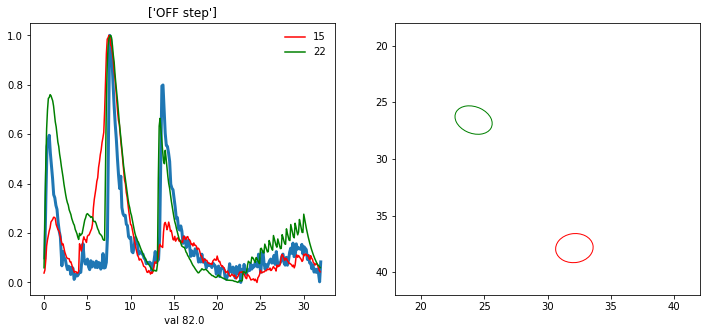

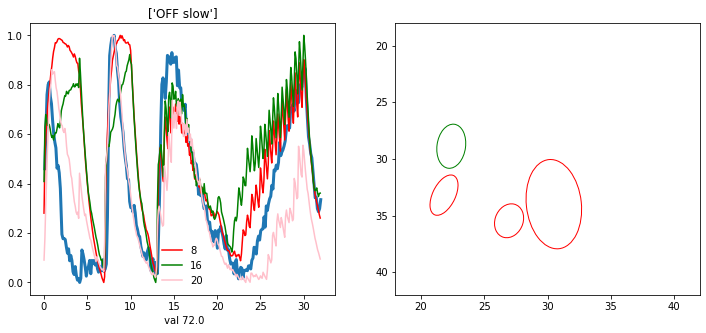

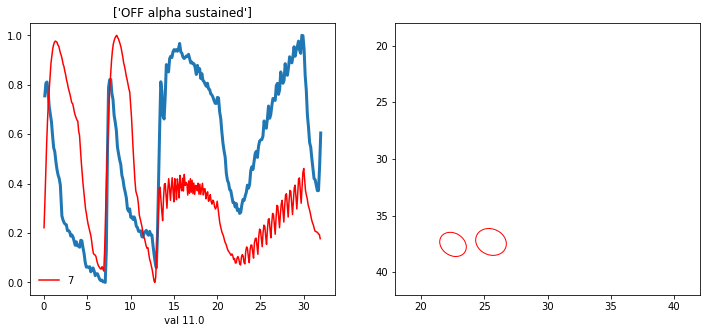

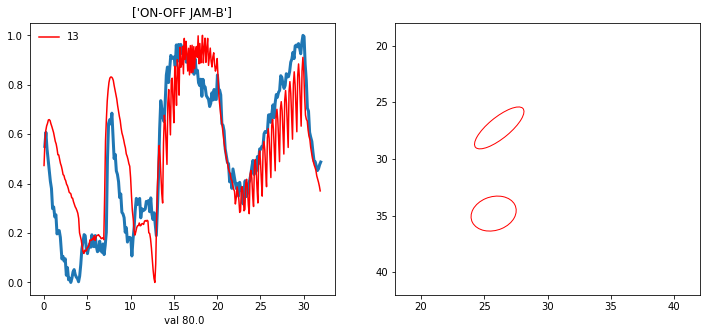

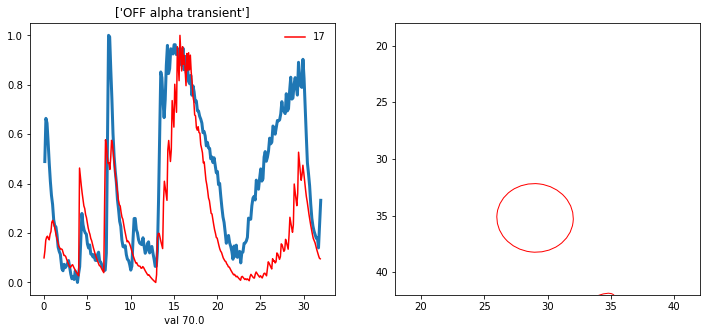

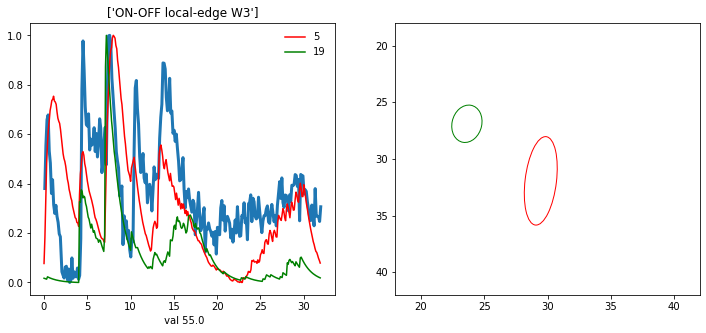

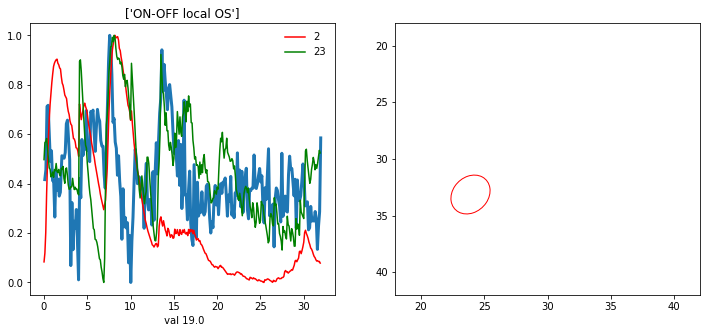

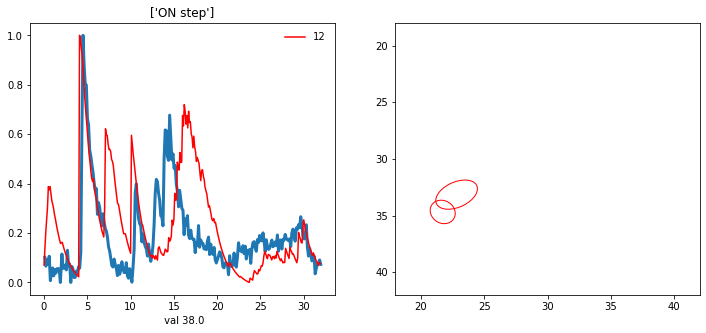

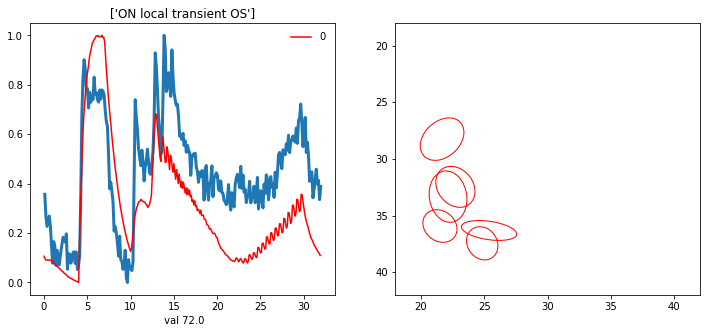

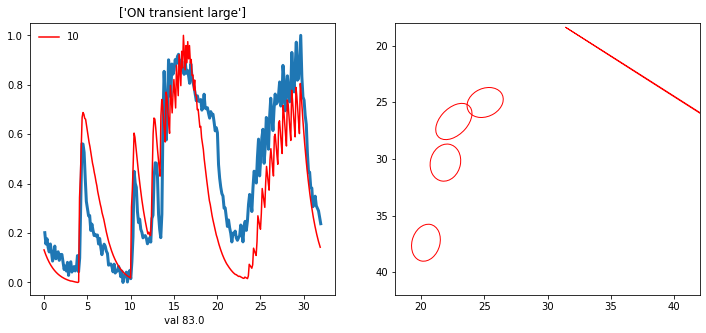

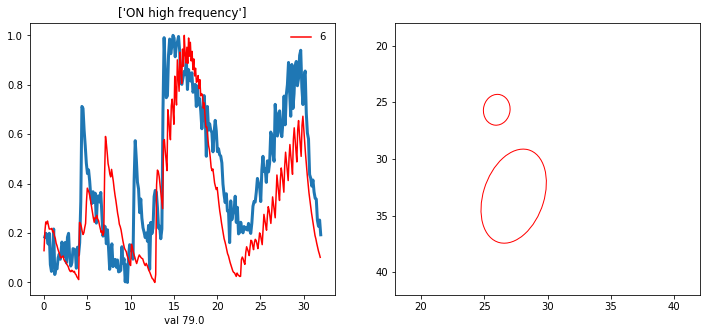

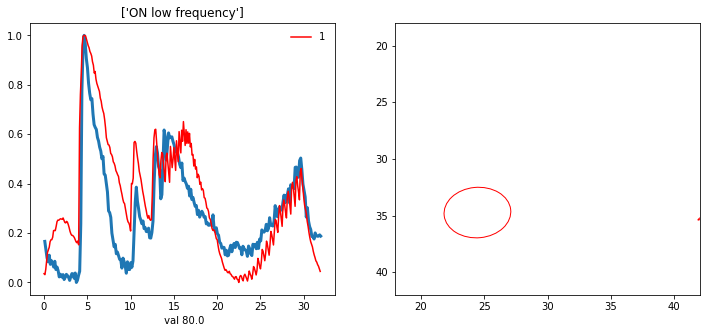

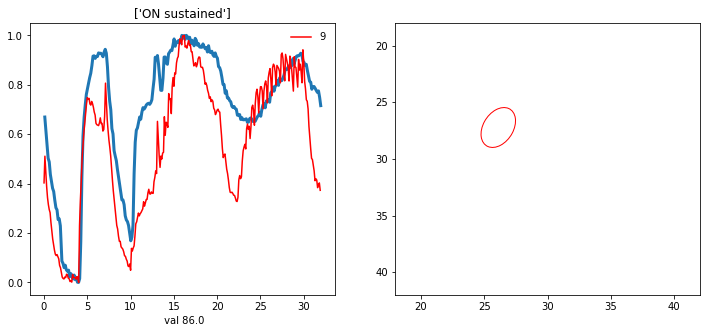

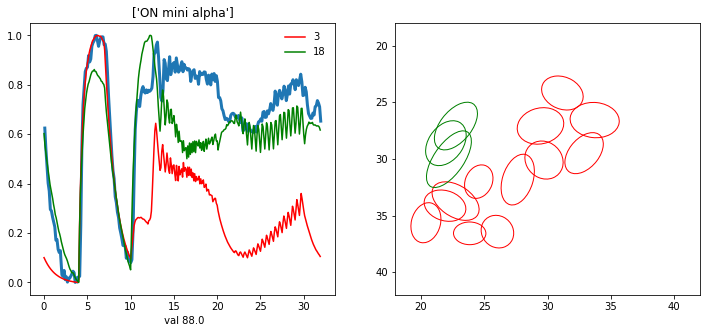

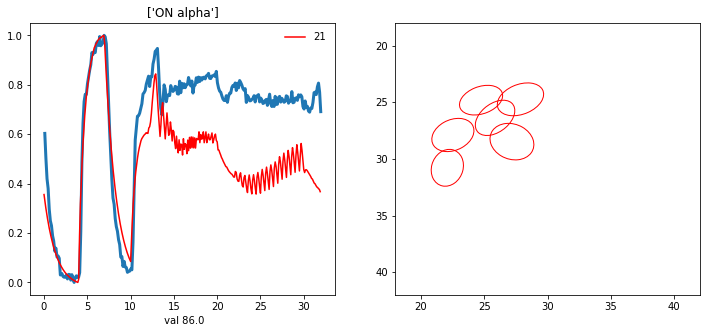

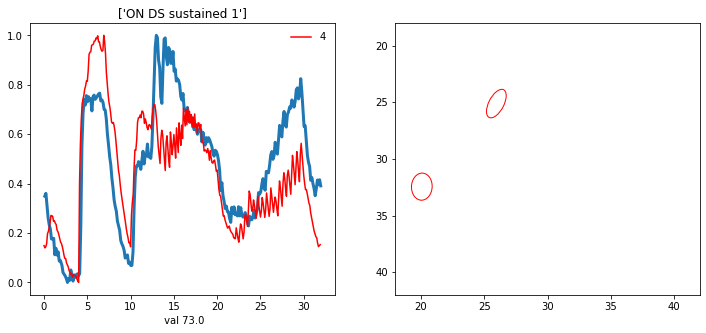

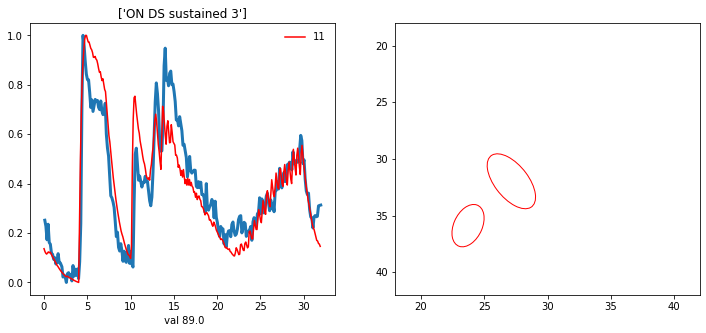

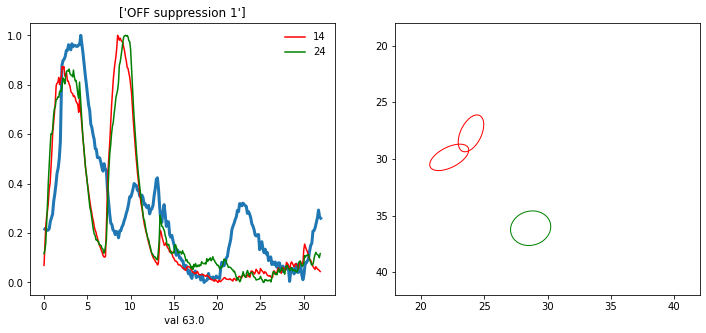

In [95]:
# Here plot the final groups

sel_badens = np.arange(32)
sel_exps = exp_labels

sel_cells = np.arange(25)

countg=0
for i in sel_badens:
    cc=0
    Plot=False
    for j in sel_cells:

        if manual_selection[j]==i:
            if not(Plot): 
                fig=figure(figsize=(12,5))
                ax1 = fig.add_subplot(1,2,1)
                ax2 = fig.add_subplot(1,2,2)
                ax1.plot(baden_time, Baden_types[i],lw=3)
                ax1.set_title(euler_labels[i])
                Plot=True
                countg+=1
            if Plot:
                
                ax1.plot(time, Exp_types_Ca[j], label = str(j), color=colors[cc+1])
                ax1.set_xlabel(' val '+str(np.round(man_vals[j]*100)) )#+ euler_labels[i][1])
                ax1.legend(frameon=False)
                
                clustersin = selected_cells[np.where((model.labels_==j))[0]]
                cc+=1
                for c in clustersin:
                    x_fit, y_fit, fitted_spatial_sta , parameters = fit_gaussian(cell_data[c]["spatial_sta"])
                    x0, y0, width, height, angle = get_ellipse_parameters(parameters, factor=1)
                    xy = (x0, y0)
                    ellipse = pcs.Ellipse(xy, width, height, angle=angle, fill=False, color = colors[cc],lw=1)
                    ax2.add_patch(ellipse)
#                     ax2.plot(cell_data[c]['ellipseMat'][0]   , cell_data[c]['ellipseMat'][1] ,color=colors[cc] ,lw=0.5)#,lw=10)    #rotated ellipse
                ax2.set_xlim(18,42)
                ax2.set_ylim(42,18)

                    
                print('Group',j, '   Baden ',i, euler_labels[i])
print('counts' ,countg)

### New cluster labels

In [96]:
new_labels = np.zeros(len(model.labels_))
for j in np.arange(len(model.labels_)):
    new_labels[j] = manual_selection[model.labels_[j]]

# here assign label to each cluster
Dic_labels={}
for i in np.arange(len(new_labels)):
    if new_labels[i]!=-1:
        Dic_labels.update({list(selected_cells)[i]: euler_labels[new_labels[i]]})
#--------------------
for c in sorted(list(Dic_labels.keys())):
     print('Clus ',c, '   Baden ',Dic_labels[c])

Clus  1    Baden  ['ON alpha']
Clus  25    Baden  ['ON local transient OS']
Clus  27    Baden  ['ON-OFF local OS']
Clus  43    Baden  ['OFF slow']
Clus  45    Baden  ['ON high frequency']
Clus  76    Baden  ['ON mini alpha']
Clus  79    Baden  ['OFF alpha transient']
Clus  80    Baden  ['OFF suppression 1']
Clus  81    Baden  ['ON local transient OS']
Clus  96    Baden  ['ON mini alpha']
Clus  123    Baden  ['ON local transient OS']
Clus  125    Baden  ['OFF suppression 1']
Clus  126    Baden  ['OFF suppression 1']
Clus  131    Baden  ['OFF suppression 1']
Clus  140    Baden  ['OFF slow']
Clus  141    Baden  ['ON transient large']
Clus  157    Baden  ['ON DS sustained 1']
Clus  170    Baden  ['ON local transient OS']
Clus  187    Baden  ['ON mini alpha']
Clus  188    Baden  ['ON-OFF local-edge W3']
Clus  192    Baden  ['ON transient large']
Clus  206    Baden  ['ON mini alpha']
Clus  236    Baden  ['ON mini alpha']
Clus  242    Baden  ['ON local transient OS']
Clus  258    Baden  ['ON 

/home/sarah/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sarah/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/sarah/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sarah/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/sarah/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sarah/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/sarah/a

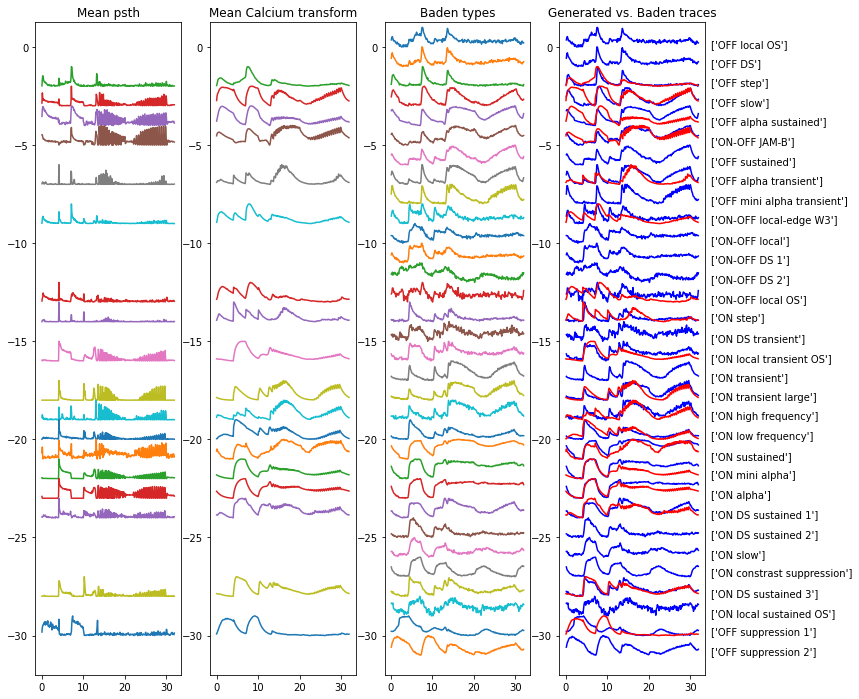

In [97]:
# Generate new experiment type traces
Exp_sorted_types = []

fig = figure(figsize=(12,12))

# Average MEA traces 
fig.add_subplot(1,4,1)
for i in euler_labels.keys():
    trace = np.mean(psth_z[(new_labels==i),:],0)
    trace = trace-min(trace)
    trace = trace/max(trace)
    Exp_sorted_types.append(trace)
    plot(time,trace-i)
    title('Mean psth')
    ylim([-32,1.25])
    
# Experiment to calcium
Exp_sorted_types_Ca = {}
fig.add_subplot(1,4,2)
for i in euler_labels.keys():
    trace = toCalciumLinear(time,Exp_sorted_types[i])
    Exp_sorted_types_Ca[i] = trace
    plot(time,trace-i)
    title('Mean Calcium transform')
    ylim([-32,1.25])
    
# Baden calcium traces
fig.add_subplot(1,4,3)
for i in euler_labels.keys():
    plot(baden_time,Baden_types[i]-i)
    ylim([-32,1.25])
    title('Baden types')

# Comparison
fig.add_subplot(1,4,4)
for i in euler_labels.keys():
    plot(baden_time,Baden_types[i]-i,'b')
    plot(time,Exp_sorted_types_Ca[i]-i,'r')
    text(35,-i,euler_labels[i])
    ylim([-32,1.25])
    title('Generated vs. Baden traces')

# Create a summary figure for each cluster type

In [98]:
for icluster in range(len(euler_labels))[0:]:
    idx_cluster = np.where(new_labels==icluster)[0]
    print(len(idx_cluster))
    
    if len(idx_cluster) > 0:

        gs = gds.GridSpec(len(idx_cluster)+3,6)

        if len(idx_cluster)<7:
            yspan = 2
        else:
            yspan=-2
        fig=figure(figsize=(14,(len(idx_cluster)+yspan)*1.75))
        plt.suptitle("Cell group {}   {}   {} cells".format(icluster,euler_labels[icluster], len(idx_cluster)),size=24)

        # Loop cells in cluster
        line = 2
        STAs=np.zeros(40)
        STAcount=0
        waves=np.zeros(101)
        wavecount=0
        
        for index in sorted(idx_cluster):
            cell_nb = list(selected_cells)[index]

            # Plot temp STA
            ax= subplot(gs[line+1,1])

            ax.set_ylim([-4,4])
            ax.axis("off")
            ax.set_aspect(0.075)
            ax.step(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta"],'k',lw=3)
            polarity = cell_data[cell_nb]["polarity"]
            ax.set_title('Cluster ' + str(cell_nb) + '  Polarity '+polarity)
            ax.axhline(0,color='k',lw=0.5)

            STAs+=cell_data[cell_nb]["temporal_sta"]
            STAcount+=1

            # Plot temp STA avg
            ax= subplot(gs[0,1])

            ax.set_title('Temp STA')
            ax.set_ylim([-4,4])
            ax.plot(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta"],lw=0.5)
            ax.axhline(0,color='k',lw=0.5)
            ax.set_xlabel('Time(s)')

            # plot Spatial STA
            ax= subplot(gs[line+1,0])
            ax.imshow(cell_data[cell_nb]["spatial_sta"], cmap='gray',interpolation='gaussian')
            ax.set_xlim(16,44)
            ax.set_ylim(44,16)
            ax.set_aspect('equal')
            ax.set_xticks([])
            ax.set_yticks([])

            #plot waveform
            ax= subplot(gs[line+1,2])
            wave = cell_data[cell_nb]["templates"]/abs(np.min(cell_data[cell_nb]["templates"]))
            ax.plot(wave,'r')
            ax.axis("off")
            ax.set_ylim([-1.25,1.25])
            waves+=wave
            wavecount+=1

            ax= subplot(gs[0,2])
            ax.plot(wave,lw=0.5)
            ax.axis("off")
            ax.set_ylim([-1.25,1.25])

            # plot Euler
            ax= subplot(gs[line+1,3:])
            cell_index=list(selected_cells).index(cell_nb)
            ax.plot(np.linspace(0,32,800),cell_data[cell_nb]["psth"])
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.set_xticks([])
            plt.locator_params(axis="y", nbins=3)

            # plot Ellipse
            x_fit, y_fit, fitted_spatial_sta , parameters = fit_gaussian(cell_data[cell_nb]["spatial_sta"])

            x0, y0, width, height, angle = get_ellipse_parameters(parameters, factor=1)
            xy = (x0, y0)

            ax= subplot(gs[line+1,0])
            ellipse = pcs.Ellipse(xy, width, height, angle=angle, fill=False, color='r',lw=1)
            ax.add_patch(ellipse)

            ax= subplot(gs[0:2,0])
            ellipse = pcs.Ellipse(xy, width, height, angle=angle, fill=False, color='k',lw=1)
            ax.add_patch(ellipse)

            line+=1

        # avg STA
        STAs=STAs/STAcount
        ax= subplot(gs[0,1])
        ax.plot(np.linspace(-40/30,0,40),STAs,'k',lw=2)
        ax.set_ylim([-4,4])
        ax.set_aspect(0.075)
        ax.axis("off")

        # avg wave
        waves=waves/wavecount
        ax= subplot(gs[0,2])
        ax.set_title('Waveform')

        ax.plot(waves,'r',lw=2)
        ax.set_ylim([-1.25,1.25])
        #ax.set_aspect(0.075)
        ax.axis("off")

        # size ellipses
        ax= subplot(gs[0:2,0])

        ax.set_title('Ellipses')
        ax.set_xlim(16,44)
        ax.set_ylim(44,16)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])

        # mean psth
        ax= subplot(gs[0,3:])
        ax.set_title('Euler psth')

        ax.plot(np.linspace(0,32,320),np.mean(psth_z[idx_cluster,:], 0),'g')
        ax.axis("off")

        # mean Ca trace + comparison
        ax= subplot(gs[1,3:])
        ax.text(-9,1,'Calcium traces')
        ax.axis("off")

        plot(time,Exp_sorted_types_Ca[icluster] ,'g')
        plot(baden_time,Baden_types[icluster],'r')

        # plot euler stim
        euler_vec= get_euler()
        ax= subplot(gs[2,3:])
        ax.plot(time_stim,euler_vec, color='k')
        ax.set_yticks([])
        ax.set_ylim([-0.25,1.25])
        ax.set_xlabel('Time(s)')
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)

        ax= subplot(gs[2,2])
        ax.text(0.5,0.5 ,"Chirp stimulus profile")
        ax.axis("off")
        
        ### Save figure

        PDF_folder = rootF + 'Documents/Myopia/Data analysis/Blur experiments/exp' + str(exp) + '/RGC typing/Baden types/'
        fsave = PDF_folder +'exp'+ str(exp) +'_badentype' +str(icluster) 

        fig.savefig(fsave+'.png',format='png',dpi=250)
        close(fig)  


0
0
2
5
2
2
0
2
0
3
0
0
0
3


/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:307: RuntimeWarning: di

2
0
6
0
5
3


/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:307: RuntimeWarning: di

3


/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:307: RuntimeWarning: di

1
15
6
2
0
0
0
2
0
4


/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
/home/sarah/Documents/GitHub/Retina_clusters_analysis/shared/functions.py:307: RuntimeWarning: di

0


# SAVE DATA

In [99]:
# Save average Ca traces for each type
fsave = exp_path + str(exp) + '_celltype_Ca_traces'
save_obj(Exp_sorted_types_Ca,fsave)

# Save Baden type for each cell in 'selected_cells'
fsave = exp_path + str(exp) + '_celltype_Baden'
save_obj(new_labels,fsave)

# Add blur data

## Load data

In [74]:
from parameters_stimulation2 import *

if laptop:
    rootF = 'C:/Users/goethas/'
else:
    rootF = '/home/sarah/'

data_path = rootF + 'Documents/Myopia/Data analysis/Blur experiments/exp' + str(exp) + '/'

blur_data = load(data_path + str(exp) + '_selected_cells_spike_count_with_noise.npz')
    
spike_counts = blur_data['spike_count']
spike_counts_mean = blur_data['spike_count_mean']
spike_counts_std = blur_data['spike_count_std']
blur_clusters = blur_data['clusters']

Ncells = len(blur_clusters)

print (shape(spike_counts))
print (blur_clusters)

(61, 4, 2, 9, 4, 25)
[  1  25  27  43  68  76  79  81  86  96 123 125 126 131 140 141 157 170
 187 192 206 230 236 242 258 259 278 305 306 314 357 366 387 390 393 396
 399 404 406 417 424 433 437 502 508 516 534 541 550 555 561 565 577 578
 588 603 604 619 625 677 681]


In [75]:
selected_cells

array([  1,  25,  27,  43,  76,  81,  96, 123, 125, 131, 140, 141, 157,
       170, 187, 197, 199, 206, 230, 236, 242, 247, 258, 259, 278, 305,
       306, 314, 357, 366, 387, 390, 396, 399, 404, 406, 417, 433, 434,
       437, 502, 508, 516, 541, 547, 550, 555, 565, 577, 578, 588, 603,
       604, 625, 677, 681])

In [76]:
pup = 0

cols = ['C0','C1','C2','C3']

for icluster in range(len(euler_labels))[0:]:
    idx_cluster = np.where(new_labels==icluster)[0]
    print(len(idx_cluster))
    
    if len(idx_cluster) > 0:

        gs = gds.GridSpec(len(idx_cluster)+3,10)

        if len(idx_cluster)<7:
            yspan = 2
        else:
            yspan=-2
        fig=figure(figsize=(20,(len(idx_cluster)+yspan)*2))
        plt.suptitle("Cell group {}   {}   {} cells".format(icluster,euler_labels[icluster], len(idx_cluster)),size=24)

        # Loop cells in cluster
        line = 2
        STAs=np.zeros(40)
        STAcount=0
        waves=np.zeros(101)
        wavecount=0
        
        for index in sorted(idx_cluster):
            cell_nb = list(selected_cells)[index]

            # Plot temp STA
            ax= subplot(gs[line+1,1])

            ax.set_ylim([-4,4])
            ax.axis("off")
            ax.set_aspect(0.075)
            ax.step(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta"],'k',lw=3)
            polarity = cell_data[cell_nb]["polarity"]
            ax.set_title('Cluster ' + str(cell_nb) + '  Polarity '+polarity)
            ax.axhline(0,color='k',lw=0.5)

            STAs+=cell_data[cell_nb]["temporal_sta"]
            STAcount+=1

            # Plot temp STA avg
            ax= subplot(gs[0,1])

            ax.set_title('Temp STA')
            ax.set_ylim([-4,4])
            ax.plot(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta"],lw=0.5)
            ax.axhline(0,color='k',lw=0.5)
            ax.set_xlabel('Time(s)')

            # plot Spatial STA
            ax= subplot(gs[line+1,0])
            ax.imshow(cell_data[cell_nb]["spatial_sta"], cmap='gray',interpolation='gaussian')
            ax.set_xlim(16,44)
            ax.set_ylim(44,16)
            ax.set_aspect('equal')
            ax.set_xticks([])
            ax.set_yticks([])

            #plot waveform
            ax= subplot(gs[line+1,2])
            wave = cell_data[cell_nb]["templates"]/abs(np.min(cell_data[cell_nb]["templates"]))
            ax.plot(wave,'r')
            ax.axis("off")
            ax.set_ylim([-1.25,1.25])
            waves+=wave
            wavecount+=1

            ax= subplot(gs[0,2])
            ax.plot(wave,lw=0.5)
            ax.axis("off")
            ax.set_ylim([-1.25,1.25])

            # plot Euler
            ax= subplot(gs[line+1,3:6])
            cell_index=list(selected_cells).index(cell_nb)
            ax.plot(np.linspace(0,32,800),cell_data[cell_nb]["psth"])
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.set_xticks([])
            plt.locator_params(axis="y", nbins=3)

            # plot Ellipse
            x_fit, y_fit, fitted_spatial_sta , parameters = fit_gaussian(cell_data[cell_nb]["spatial_sta"])

            x0, y0, width, height, angle = get_ellipse_parameters(parameters, factor=1)
            xy = (x0, y0)

            ax= subplot(gs[line+1,0])
            ellipse = pcs.Ellipse(xy, width, height, angle=angle, fill=False, color='r',lw=1)
            ax.add_patch(ellipse)

            ax= subplot(gs[0:2,0])
            ellipse = pcs.Ellipse(xy, width, height, angle=angle, fill=False, color='k',lw=1)
            ax.add_patch(ellipse)
            
            ##### Cells reponse to blur
            index_bl = where(blur_clusters == selected_cells[index])[0]
            print (selected_cells[index], blur_clusters[index_bl])
            if len(index_bl) > 0:
                index_bl = index_bl[0]
                max_act = nanmax(spike_counts_mean[index_bl])

                for src in range(Nsources):
                    ax = fig.add_subplot(gs[line+1, src + 6])
                    for iImg in range(Nimgs):
                        ax.plot(dFs, spike_counts_mean[index_bl, iImg, pup, :, src],'-', \
                                color=cols[iImg])
                        ax.spines['top'].set_visible(False)
                        ax.spines['right'].set_visible(False)
                        ax.set_ylim(0,1.5*max_act)
                        ax.set_xlim(0, 9)
                        ax.set_xticks(dFs[::2])
                        if line == 2:
                            ax.set_title('Ecc = {}°'.format(sourcesEcc[src]))
                            ax.set_xticklabels([])
                        if src == 0:
                            ax.set_ylabel('Spike cnt')
                        else:
                            ax.set_yticks([])
                        if line == len(idx_cluster)+1:
                            ax.set_xlabel('Defocus (D)')
                        else:
                            ax.set_xticks([])

            line+=1

        # avg STA
        STAs=STAs/STAcount
        ax= subplot(gs[0,1])
        ax.plot(np.linspace(-40/30,0,40),STAs,'k',lw=2)
        ax.set_ylim([-4,4])
        ax.set_aspect(0.075)
        ax.axis("off")

        # avg wave
        waves=waves/wavecount
        ax= subplot(gs[0,2])
        ax.set_title('Waveform')

        ax.plot(waves,'r',lw=2)
        ax.set_ylim([-1.25,1.25])
        #ax.set_aspect(0.075)
        ax.axis("off")

        # size ellipses
        ax= subplot(gs[0:2,0])

        ax.set_title('Ellipses')
        ax.set_xlim(16,44)
        ax.set_ylim(44,16)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])

        # mean psth
        ax= subplot(gs[0,3:6])
        ax.set_title('Euler psth')

        ax.plot(np.linspace(0,32,320),np.mean(psth_z[idx_cluster,:], 0),'g')
        ax.axis("off")

        # mean Ca trace + comparison
        ax= subplot(gs[1,3:])
        ax.text(-9,1,'Calcium traces')
        ax.axis("off")

        plot(time,Exp_sorted_types_Ca[icluster] ,'g')
        plot(baden_time,Baden_types[icluster],'r')

        # plot euler stim
        euler_vec= get_euler()
        ax= subplot(gs[2,3:6])
        ax.plot(time_stim,euler_vec, color='k')
        ax.set_yticks([])
        ax.set_ylim([-0.25,1.25])
        ax.set_xlabel('Time(s)')
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)

        ax= subplot(gs[2,2])
        ax.text(0.5,0.5 ,"Chirp stimulus profile")
        ax.axis("off")
        
        ### Save figure

        PDF_folder = rootF + 'Documents/Myopia/Data analysis/Blur experiments/exp' + str(exp) + '/RGC typing/Baden types/'
        fsave = PDF_folder +'exp'+ str(exp) +'_blur_and_badentype' +str(icluster) 

        fig.savefig(fsave+'.png',format='png',dpi=250)
        close(fig)  


0
0
1
390 [390]
2
199 []
230 [230]
2
366 [366]
399 [399]
0
0
0
0
1
278 [278]
5
25 [25]
81 [81]
123 [123]
242 [242]
550 [550]
14
76 [76]
170 [170]
187 [187]
206 [206]
236 [236]
306 [306]
434 []
502 [502]
541 [541]
555 [555]
565 [565]
577 [577]
578 [578]
603 [603]
0
0
0
0
0
4
141 [141]
314 [314]
357 [357]
417 [417]
0
0
4
157 [157]
305 [305]
387 [387]
547 []
1
588 [588]
6
1 [1]
258 [258]
404 [404]
406 [406]
433 [433]
604 [604]
5
96 [96]
197 []
259 [259]
396 [396]
516 [516]
0
0
0
0
0
0
1
681 [681]
10
27 [27]
43 [43]
125 [125]
131 [131]
140 [140]
247 []
437 [437]
508 [508]
625 [625]
677 [677]
